In [6]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as utils

import helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import norm

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [8]:
biwi = pd.read_csv('./data/train/biwi/biwi_hotel.txt', header = None,
                 names = ['frameNb','id', 'x','y'],delimiter=' ')
id_unique = np.unique(np.array(biwi['id']))

init = np.zeros(len(biwi)) 
biwi['Speed'] = init
biwi['Angle'] = init
biwi['Vx'] = init
biwi['Vy'] = init

In [9]:
pd.options.mode.chained_assignment = None ## Disable StettingWithCopy warning
c = 0
for i in id_unique:
    a = biwi[biwi['id']==i]
    ind = a.index
    a.index = range(len(a))
    dist = a['x'].iloc
    dist1 = a.loc[0:len(a)-2,'x':'y']
    dist1.index=range(len(dist1))
    dist2 = a.loc[1:,'x':'y']
    dist2.index=range(len(dist2))
    dist = dist2-dist1
    b = len(dist)
    if c < b:
        vector_speed = np.zeros((len(id_unique),b,2))
        c=b
b = 0
for i in id_unique:
    a = biwi[biwi['id']==i]
    ind = a.index
    a.index = range(len(a))
    dist = a['x'].iloc
    dist1 = a.loc[0:len(a)-2,'x':'y']
    dist1.index=range(len(dist1))
    dist2 = a.loc[1:,'x':'y']
    dist2.index=range(len(dist2))
    dist = dist2-dist1
    speed = np.array(np.sqrt(dist['x']**2+dist['y']**2)/0.4)
    biwi.loc[ind[1:],'Speed'] = speed
    angle=np.zeros(len(dist)-1)
    vx=np.zeros(len(dist))
    vy=np.zeros(len(dist))
    for j in range(len(dist)-1):
        if norm(dist.loc[j,:])==0 or norm(dist.loc[j+1,:])==0:
            angle[j]=0
        elif np.cross(dist.loc[j,:],dist.loc[j+1,:])/(norm(dist.loc[j,:])*norm(dist.loc[j+1,:]))>1:
            angle[j]=np.arcsin(1)
        else:
            angle[j]=np.arcsin(np.cross(dist.loc[j,:],dist.loc[j+1,:])/(norm(dist.loc[j,:])*norm(dist.loc[j+1,:])))
    
    for j in range(len(dist)):
        if j == 0:
            vx[j] = 0
            vy[j] = speed[j]
            vector_speed[b][j][0]=vx[j]
            vector_speed[b][j][1]=vy[j]
        else:
            vx[j] = speed[j]*np.sin(sum(angle[:j]))
            vy[j] = speed[j]*np.cos(sum(angle[:j]))
            vector_speed[b][j][0]=vx[j]
            vector_speed[b][j][1]=vy[j]
    
    biwi.loc[ind[2:],'Angle'] = angle
    biwi.loc[ind[1:],'Vx'] = vx
    biwi.loc[ind[1:],'Vy'] = vy
    b+=1

In [10]:
x = np.zeros((len(vector_speed),9,2))
y = np.zeros((len(vector_speed),9,2))
for i in range(len(vector_speed)):
    x[i][:][:] = vector_speed[i][:9][:]
    y[i][:][:] = vector_speed[i][10:19][:]

mask = list(range(len(vector_speed)-20, len(vector_speed)))
x_val = x[mask]
y_val = y[mask]
mask = list(range(len(vector_speed)-20))
x_train = x[mask]
y_train = y[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([125, 1, 9, 2])
Train labels shape:  torch.Size([125, 1, 9, 2])
Validation data shape:  torch.Size([20, 1, 9, 2])
Validation labels shape:  torch.Size([20, 1, 9, 2])


In [11]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv2d(n_input_channels,3,5,padding=2)
        self.conv1_bn = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(9*2 * 3, 9*2 * 1)
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = x.view(-1, 9*2 * 3) # in order to reshape the tensor for as many columns we need
        x = self.fc1(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

/Users/4romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20.. Loss: 0.4926.. Test accuracy: 0.5460.. 0.0250 s/batch  steps 2.0000
Epoch: 1/20.. Loss: 0.8221.. Test accuracy: 0.5460.. 0.0010 s/batch  steps 4.0000
Epoch: 1/20.. Loss: 0.6094.. Test accuracy: 0.5459.. 0.0011 s/batch  steps 6.0000
Epoch: 1/20.. Loss: 0.7486.. Test accuracy: 0.5460.. 0.0007 s/batch  steps 8.0000
Epoch: 1/20.. Loss: 0.7076.. Test accuracy: 0.5459.. 0.0007 s/batch  steps 10.0000
Epoch: 1/20.. Loss: 0.4807.. Test accuracy: 0.5459.. 0.0008 s/batch  steps 12.0000
Epoch: 1/20.. Loss: 0.5801.. Test accuracy: 0.5460.. 0.0008 s/batch  steps 14.0000
Epoch: 1/20.. Loss: 0.2609.. Test accuracy: 0.5460.. 0.0008 s/batch  steps 16.0000
Epoch: 1/20.. Loss: 0.2974.. Test accuracy: 0.5460.. 0.0008 s/batch  steps 18.0000
Epoch: 1/20.. Loss: 1.2134.. Test accuracy: 0.5459.. 0.0007 s/batch  steps 20.0000
Epoch: 1/20.. Loss: 0.7220.. Test accuracy: 0.5460.. 0.0008 s/batch  steps 22.0000
Epoch: 1/20.. Loss: 0.3345.. Test accuracy: 0.5459.. 0.0009 s/batch  steps 24.0000
Epoch: 2

Epoch: 9/20.. Loss: 0.6050.. Test accuracy: 0.5459.. 0.0007 s/batch  steps 202.0000
Epoch: 9/20.. Loss: 0.7336.. Test accuracy: 0.5457.. 0.0011 s/batch  steps 204.0000
Epoch: 9/20.. Loss: 0.5753.. Test accuracy: 0.5458.. 0.0007 s/batch  steps 206.0000
Epoch: 9/20.. Loss: 0.6529.. Test accuracy: 0.5458.. 0.0009 s/batch  steps 208.0000
Epoch: 9/20.. Loss: 0.8261.. Test accuracy: 0.5458.. 0.0010 s/batch  steps 210.0000
Epoch: 9/20.. Loss: 1.1260.. Test accuracy: 0.5459.. 0.0008 s/batch  steps 212.0000
Epoch: 9/20.. Loss: 0.9995.. Test accuracy: 0.5457.. 0.0008 s/batch  steps 214.0000
Epoch: 9/20.. Loss: 0.9612.. Test accuracy: 0.5458.. 0.0007 s/batch  steps 216.0000
Epoch: 9/20.. Loss: 0.0708.. Test accuracy: 0.5457.. 0.0006 s/batch  steps 218.0000
Epoch: 9/20.. Loss: 0.4200.. Test accuracy: 0.5456.. 0.0007 s/batch  steps 220.0000
Epoch: 9/20.. Loss: 0.6721.. Test accuracy: 0.5458.. 0.0006 s/batch  steps 222.0000
Epoch: 9/20.. Loss: 0.2869.. Test accuracy: 0.5456.. 0.0007 s/batch  steps 2

Epoch: 17/20.. Loss: 0.6159.. Test accuracy: 0.5455.. 0.0008 s/batch  steps 420.0000
Epoch: 17/20.. Loss: 0.9007.. Test accuracy: 0.5456.. 0.0012 s/batch  steps 422.0000
Epoch: 17/20.. Loss: 0.9882.. Test accuracy: 0.5456.. 0.0013 s/batch  steps 424.0000
Epoch: 18/20.. Loss: 0.1764.. Test accuracy: 0.5455.. 0.0007 s/batch  steps 426.0000
Epoch: 18/20.. Loss: 0.8824.. Test accuracy: 0.5456.. 0.0012 s/batch  steps 428.0000
Epoch: 18/20.. Loss: 0.2140.. Test accuracy: 0.5455.. 0.0016 s/batch  steps 430.0000
Epoch: 18/20.. Loss: 0.8348.. Test accuracy: 0.5455.. 0.0012 s/batch  steps 432.0000
Epoch: 18/20.. Loss: 0.7488.. Test accuracy: 0.5455.. 0.0009 s/batch  steps 434.0000
Epoch: 18/20.. Loss: 1.1871.. Test accuracy: 0.5455.. 0.0013 s/batch  steps 436.0000
Epoch: 18/20.. Loss: 0.2698.. Test accuracy: 0.5455.. 0.0013 s/batch  steps 438.0000
Epoch: 18/20.. Loss: 0.6701.. Test accuracy: 0.5455.. 0.0010 s/batch  steps 440.0000
Epoch: 18/20.. Loss: 0.4906.. Test accuracy: 0.5455.. 0.0010 s/ba

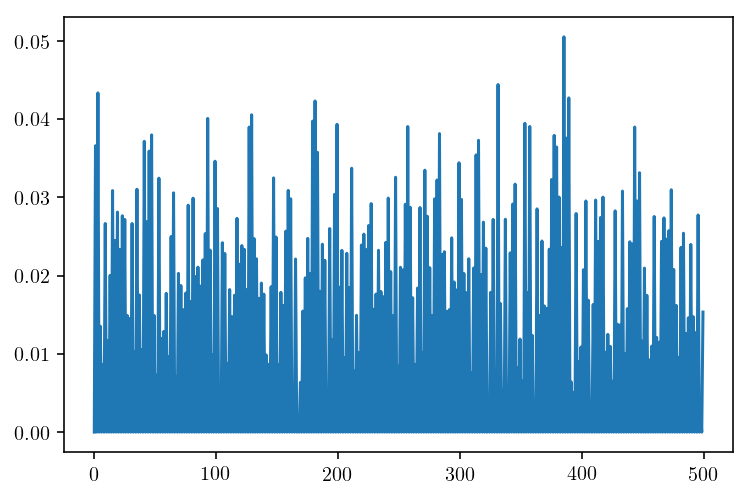

In [12]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, weight_decay=1e-4)
epochs = 20
steps = 0
running_loss = 0
print_every = 2
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inputs)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inputs = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inputs)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "Test accuracy: {:.4f}..".format(sum_accuracy/(ii+1)),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

plt.plot(range(epochs*25),vec_acc_)
plt.show()

In [83]:
accuracy = np.mean(predicted == inputs)

TypeError: eq received an invalid combination of arguments - got (Variable), but expected one of:
 * (float value)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)
 * (torch.FloatTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)


In [57]:
Vector_create = np.random.rand(1000,19,2)

In [58]:
x = np.zeros((len(Vector_create),9,2))
y = np.zeros((len(Vector_create),9,2))
for i in range(len(Vector_create)):
    x[i][:][:] = Vector_create[i][:9][:]
    y[i][:][:] = Vector_create[i][10:19][:]

mask = list(range(len(Vector_create)-50, len(Vector_create)))
x_val = x[mask]
y_val = y[mask]
mask = list(range(len(Vector_create)-50))
x_train = x[mask]
y_train = y[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([950, 1, 9, 2])
Train labels shape:  torch.Size([950, 1, 9, 2])
Validation data shape:  torch.Size([50, 1, 9, 2])
Validation labels shape:  torch.Size([50, 1, 9, 2])


In [60]:
class ConvNetcreate(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv2d(n_input_channels,3,5,padding=2)
        self.conv1_bn = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(9*2 * 3, 9*2 * 1)
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = x.view(-1, 9*2 * 3) # in order to reshape the tensor for as many columns we need
        x = self.fc1(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [63]:
net = ConvNetcreate()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, weight_decay=1e-4)
epochs = 20
steps = 0
running_loss = 0
print_every = 2
#vec_acc_ = np.zeros(epochs*50)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inputs)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inputs = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inputs)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                #vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "Test accuracy: {:.4f}..".format(sum_accuracy/(ii+1)),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

#plt.plot(range(epochs*25),vec_acc_)
#plt.show()

/Users/4romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20.. Loss: 0.2787.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2.0000
Epoch: 1/20.. Loss: 0.2637.. Test accuracy: 0.2802.. 0.0009 s/batch  steps 4.0000
Epoch: 1/20.. Loss: 0.2871.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 6.0000
Epoch: 1/20.. Loss: 0.2638.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 8.0000
Epoch: 1/20.. Loss: 0.2765.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 10.0000
Epoch: 1/20.. Loss: 0.2986.. Test accuracy: 0.2802.. 0.0011 s/batch  steps 12.0000
Epoch: 1/20.. Loss: 0.3309.. Test accuracy: 0.2802.. 0.0008 s/batch  steps 14.0000
Epoch: 1/20.. Loss: 0.3209.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 16.0000
Epoch: 1/20.. Loss: 0.2813.. Test accuracy: 0.2802.. 0.0011 s/batch  steps 18.0000
Epoch: 1/20.. Loss: 0.2972.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 20.0000
Epoch: 1/20.. Loss: 0.2977.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 22.0000
Epoch: 1/20.. Loss: 0.3520.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 24.0000
Epoch: 1

Epoch: 2/20.. Loss: 0.2549.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 208.0000
Epoch: 2/20.. Loss: 0.3390.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 210.0000
Epoch: 2/20.. Loss: 0.2437.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 212.0000
Epoch: 2/20.. Loss: 0.3352.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 214.0000
Epoch: 2/20.. Loss: 0.2678.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 216.0000
Epoch: 2/20.. Loss: 0.3210.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 218.0000
Epoch: 2/20.. Loss: 0.2527.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 220.0000
Epoch: 2/20.. Loss: 0.2384.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 222.0000
Epoch: 2/20.. Loss: 0.3110.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 224.0000
Epoch: 2/20.. Loss: 0.3212.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 226.0000
Epoch: 2/20.. Loss: 0.2945.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 228.0000
Epoch: 2/20.. Loss: 0.3124.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2

Epoch: 3/20.. Loss: 0.2904.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 410.0000
Epoch: 3/20.. Loss: 0.2900.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 412.0000
Epoch: 3/20.. Loss: 0.2561.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 414.0000
Epoch: 3/20.. Loss: 0.2660.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 416.0000
Epoch: 3/20.. Loss: 0.2657.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 418.0000
Epoch: 3/20.. Loss: 0.2692.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 420.0000
Epoch: 3/20.. Loss: 0.2272.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 422.0000
Epoch: 3/20.. Loss: 0.3085.. Test accuracy: 0.2801.. 0.0006 s/batch  steps 424.0000
Epoch: 3/20.. Loss: 0.3915.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 426.0000
Epoch: 3/20.. Loss: 0.3358.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 428.0000
Epoch: 3/20.. Loss: 0.2407.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 430.0000
Epoch: 3/20.. Loss: 0.2707.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 4

Epoch: 4/20.. Loss: 0.2856.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 606.0000
Epoch: 4/20.. Loss: 0.2462.. Test accuracy: 0.2801.. 0.0016 s/batch  steps 608.0000
Epoch: 4/20.. Loss: 0.2605.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 610.0000
Epoch: 4/20.. Loss: 0.2728.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 612.0000
Epoch: 4/20.. Loss: 0.2452.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 614.0000
Epoch: 4/20.. Loss: 0.2519.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 616.0000
Epoch: 4/20.. Loss: 0.2980.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 618.0000
Epoch: 4/20.. Loss: 0.2496.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 620.0000
Epoch: 4/20.. Loss: 0.2767.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 622.0000
Epoch: 4/20.. Loss: 0.2545.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 624.0000
Epoch: 4/20.. Loss: 0.2270.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 626.0000
Epoch: 4/20.. Loss: 0.2133.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 6

Epoch: 5/20.. Loss: 0.2484.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 810.0000
Epoch: 5/20.. Loss: 0.1948.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 812.0000
Epoch: 5/20.. Loss: 0.2328.. Test accuracy: 0.2801.. 0.0020 s/batch  steps 814.0000
Epoch: 5/20.. Loss: 0.2659.. Test accuracy: 0.2801.. 0.0016 s/batch  steps 816.0000
Epoch: 5/20.. Loss: 0.2485.. Test accuracy: 0.2801.. 0.0016 s/batch  steps 818.0000
Epoch: 5/20.. Loss: 0.2678.. Test accuracy: 0.2801.. 0.0017 s/batch  steps 820.0000
Epoch: 5/20.. Loss: 0.2374.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 822.0000
Epoch: 5/20.. Loss: 0.1921.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 824.0000
Epoch: 5/20.. Loss: 0.2378.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 826.0000
Epoch: 5/20.. Loss: 0.2534.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 828.0000
Epoch: 5/20.. Loss: 0.2046.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 830.0000
Epoch: 5/20.. Loss: 0.2918.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 8

Epoch: 6/20.. Loss: 0.2383.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1008.0000
Epoch: 6/20.. Loss: 0.1987.. Test accuracy: 0.2801.. 0.0013 s/batch  steps 1010.0000
Epoch: 6/20.. Loss: 0.2204.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 1012.0000
Epoch: 6/20.. Loss: 0.2270.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1014.0000
Epoch: 6/20.. Loss: 0.2281.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1016.0000
Epoch: 6/20.. Loss: 0.1863.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1018.0000
Epoch: 6/20.. Loss: 0.2232.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1020.0000
Epoch: 6/20.. Loss: 0.3196.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1022.0000
Epoch: 6/20.. Loss: 0.2641.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1024.0000
Epoch: 6/20.. Loss: 0.2020.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1026.0000
Epoch: 6/20.. Loss: 0.2268.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1028.0000
Epoch: 6/20.. Loss: 0.2799.. Test accuracy: 0.2801.. 0.0009 s/bat

Epoch: 7/20.. Loss: 0.2354.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1210.0000
Epoch: 7/20.. Loss: 0.1963.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1212.0000
Epoch: 7/20.. Loss: 0.2521.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1214.0000
Epoch: 7/20.. Loss: 0.2226.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 1216.0000
Epoch: 7/20.. Loss: 0.2090.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1218.0000
Epoch: 7/20.. Loss: 0.2024.. Test accuracy: 0.2801.. 0.0013 s/batch  steps 1220.0000
Epoch: 7/20.. Loss: 0.2144.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1222.0000
Epoch: 7/20.. Loss: 0.2572.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1224.0000
Epoch: 7/20.. Loss: 0.2004.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1226.0000
Epoch: 7/20.. Loss: 0.1999.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 1228.0000
Epoch: 7/20.. Loss: 0.1951.. Test accuracy: 0.2801.. 0.0015 s/batch  steps 1230.0000
Epoch: 7/20.. Loss: 0.2393.. Test accuracy: 0.2801.. 0.0009 s/bat

Epoch: 8/20.. Loss: 0.2130.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1410.0000
Epoch: 8/20.. Loss: 0.2009.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1412.0000
Epoch: 8/20.. Loss: 0.2277.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1414.0000
Epoch: 8/20.. Loss: 0.2751.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1416.0000
Epoch: 8/20.. Loss: 0.2090.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 1418.0000
Epoch: 8/20.. Loss: 0.1961.. Test accuracy: 0.2801.. 0.0015 s/batch  steps 1420.0000
Epoch: 8/20.. Loss: 0.2048.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1422.0000
Epoch: 8/20.. Loss: 0.2232.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1424.0000
Epoch: 8/20.. Loss: 0.2214.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1426.0000
Epoch: 8/20.. Loss: 0.2626.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1428.0000
Epoch: 8/20.. Loss: 0.2065.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1430.0000
Epoch: 8/20.. Loss: 0.1973.. Test accuracy: 0.2801.. 0.0007 s/bat

Epoch: 9/20.. Loss: 0.2238.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1610.0000
Epoch: 9/20.. Loss: 0.1938.. Test accuracy: 0.2801.. 0.0014 s/batch  steps 1612.0000
Epoch: 9/20.. Loss: 0.2315.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1614.0000
Epoch: 9/20.. Loss: 0.1924.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1616.0000
Epoch: 9/20.. Loss: 0.2176.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1618.0000
Epoch: 9/20.. Loss: 0.2182.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1620.0000
Epoch: 9/20.. Loss: 0.1825.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1622.0000
Epoch: 9/20.. Loss: 0.1640.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1624.0000
Epoch: 9/20.. Loss: 0.1961.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1626.0000
Epoch: 9/20.. Loss: 0.1904.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1628.0000
Epoch: 9/20.. Loss: 0.2102.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 1630.0000
Epoch: 9/20.. Loss: 0.2056.. Test accuracy: 0.2801.. 0.0010 s/bat

Epoch: 10/20.. Loss: 0.1401.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1806.0000
Epoch: 10/20.. Loss: 0.1672.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1808.0000
Epoch: 10/20.. Loss: 0.1822.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1810.0000
Epoch: 10/20.. Loss: 0.1528.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1812.0000
Epoch: 10/20.. Loss: 0.2101.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1814.0000
Epoch: 10/20.. Loss: 0.2029.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1816.0000
Epoch: 10/20.. Loss: 0.1708.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 1818.0000
Epoch: 10/20.. Loss: 0.1402.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1820.0000
Epoch: 10/20.. Loss: 0.1669.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 1822.0000
Epoch: 10/20.. Loss: 0.1871.. Test accuracy: 0.2801.. 0.0014 s/batch  steps 1824.0000
Epoch: 10/20.. Loss: 0.1880.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 1826.0000
Epoch: 10/20.. Loss: 0.2077.. Test accuracy: 0.2801.. 

Epoch: 11/20.. Loss: 0.1631.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2002.0000
Epoch: 11/20.. Loss: 0.2089.. Test accuracy: 0.2801.. 0.0013 s/batch  steps 2004.0000
Epoch: 11/20.. Loss: 0.1812.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2006.0000
Epoch: 11/20.. Loss: 0.1685.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 2008.0000
Epoch: 11/20.. Loss: 0.1513.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2010.0000
Epoch: 11/20.. Loss: 0.1508.. Test accuracy: 0.2801.. 0.0015 s/batch  steps 2012.0000
Epoch: 11/20.. Loss: 0.1658.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2014.0000
Epoch: 11/20.. Loss: 0.1311.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2016.0000
Epoch: 11/20.. Loss: 0.1868.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2018.0000
Epoch: 11/20.. Loss: 0.1658.. Test accuracy: 0.2801.. 0.0015 s/batch  steps 2020.0000
Epoch: 11/20.. Loss: 0.2074.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2022.0000
Epoch: 11/20.. Loss: 0.1911.. Test accuracy: 0.2801.. 

Epoch: 12/20.. Loss: 0.1907.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2196.0000
Epoch: 12/20.. Loss: 0.1638.. Test accuracy: 0.2801.. 0.0013 s/batch  steps 2198.0000
Epoch: 12/20.. Loss: 0.1570.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2200.0000
Epoch: 12/20.. Loss: 0.1416.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2202.0000
Epoch: 12/20.. Loss: 0.1688.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2204.0000
Epoch: 12/20.. Loss: 0.1652.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2206.0000
Epoch: 12/20.. Loss: 0.1669.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2208.0000
Epoch: 12/20.. Loss: 0.1787.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2210.0000
Epoch: 12/20.. Loss: 0.1488.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2212.0000
Epoch: 12/20.. Loss: 0.1669.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2214.0000
Epoch: 12/20.. Loss: 0.1768.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2216.0000
Epoch: 12/20.. Loss: 0.1753.. Test accuracy: 0.2801.. 

Epoch: 13/20.. Loss: 0.1482.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2392.0000
Epoch: 13/20.. Loss: 0.1807.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2394.0000
Epoch: 13/20.. Loss: 0.1282.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2396.0000
Epoch: 13/20.. Loss: 0.1536.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2398.0000
Epoch: 13/20.. Loss: 0.1742.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2400.0000
Epoch: 13/20.. Loss: 0.1416.. Test accuracy: 0.2801.. 0.0013 s/batch  steps 2402.0000
Epoch: 13/20.. Loss: 0.1504.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2404.0000
Epoch: 13/20.. Loss: 0.1630.. Test accuracy: 0.2801.. 0.0015 s/batch  steps 2406.0000
Epoch: 13/20.. Loss: 0.1542.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2408.0000
Epoch: 13/20.. Loss: 0.1823.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2410.0000
Epoch: 13/20.. Loss: 0.1460.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2412.0000
Epoch: 13/20.. Loss: 0.1611.. Test accuracy: 0.2801.. 

Epoch: 14/20.. Loss: 0.1347.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 2588.0000
Epoch: 14/20.. Loss: 0.1296.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2590.0000
Epoch: 14/20.. Loss: 0.1299.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2592.0000
Epoch: 14/20.. Loss: 0.1518.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2594.0000
Epoch: 14/20.. Loss: 0.1817.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2596.0000
Epoch: 14/20.. Loss: 0.1829.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2598.0000
Epoch: 14/20.. Loss: 0.1479.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2600.0000
Epoch: 14/20.. Loss: 0.1570.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2602.0000
Epoch: 14/20.. Loss: 0.1548.. Test accuracy: 0.2801.. 0.0014 s/batch  steps 2604.0000
Epoch: 14/20.. Loss: 0.1395.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2606.0000
Epoch: 14/20.. Loss: 0.1593.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2608.0000
Epoch: 14/20.. Loss: 0.1624.. Test accuracy: 0.2801.. 

Epoch: 15/20.. Loss: 0.1961.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2782.0000
Epoch: 15/20.. Loss: 0.1496.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2784.0000
Epoch: 15/20.. Loss: 0.1380.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2786.0000
Epoch: 15/20.. Loss: 0.1303.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2788.0000
Epoch: 15/20.. Loss: 0.1159.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2790.0000
Epoch: 15/20.. Loss: 0.1268.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2792.0000
Epoch: 15/20.. Loss: 0.1341.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2794.0000
Epoch: 15/20.. Loss: 0.1656.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2796.0000
Epoch: 15/20.. Loss: 0.1473.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2798.0000
Epoch: 15/20.. Loss: 0.1528.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2800.0000
Epoch: 15/20.. Loss: 0.1449.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2802.0000
Epoch: 15/20.. Loss: 0.1421.. Test accuracy: 0.2801.. 

Epoch: 16/20.. Loss: 0.1333.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2974.0000
Epoch: 16/20.. Loss: 0.1606.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2976.0000
Epoch: 16/20.. Loss: 0.1458.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2978.0000
Epoch: 16/20.. Loss: 0.1233.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2980.0000
Epoch: 16/20.. Loss: 0.1777.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2982.0000
Epoch: 16/20.. Loss: 0.1225.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 2984.0000
Epoch: 16/20.. Loss: 0.1592.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2986.0000
Epoch: 16/20.. Loss: 0.1137.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 2988.0000
Epoch: 16/20.. Loss: 0.1326.. Test accuracy: 0.2801.. 0.0011 s/batch  steps 2990.0000
Epoch: 16/20.. Loss: 0.1376.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 2992.0000
Epoch: 16/20.. Loss: 0.1183.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 2994.0000
Epoch: 16/20.. Loss: 0.1547.. Test accuracy: 0.2801.. 

Epoch: 17/20.. Loss: 0.1270.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 3174.0000
Epoch: 17/20.. Loss: 0.1657.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 3176.0000
Epoch: 17/20.. Loss: 0.1290.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 3178.0000
Epoch: 17/20.. Loss: 0.1600.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 3180.0000
Epoch: 17/20.. Loss: 0.1171.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 3182.0000
Epoch: 17/20.. Loss: 0.1320.. Test accuracy: 0.2800.. 0.0012 s/batch  steps 3184.0000
Epoch: 17/20.. Loss: 0.1391.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 3186.0000
Epoch: 17/20.. Loss: 0.1302.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 3188.0000
Epoch: 17/20.. Loss: 0.1080.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 3190.0000
Epoch: 17/20.. Loss: 0.1247.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 3192.0000
Epoch: 17/20.. Loss: 0.1412.. Test accuracy: 0.2800.. 0.0009 s/batch  steps 3194.0000
Epoch: 17/20.. Loss: 0.1332.. Test accuracy: 0.2801.. 

Epoch: 18/20.. Loss: 0.1362.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 3368.0000
Epoch: 18/20.. Loss: 0.1436.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 3370.0000
Epoch: 18/20.. Loss: 0.1197.. Test accuracy: 0.2801.. 0.0008 s/batch  steps 3372.0000
Epoch: 18/20.. Loss: 0.1144.. Test accuracy: 0.2801.. 0.0019 s/batch  steps 3374.0000
Epoch: 18/20.. Loss: 0.1102.. Test accuracy: 0.2800.. 0.0013 s/batch  steps 3376.0000
Epoch: 18/20.. Loss: 0.1302.. Test accuracy: 0.2800.. 0.0014 s/batch  steps 3378.0000
Epoch: 18/20.. Loss: 0.1242.. Test accuracy: 0.2800.. 0.0012 s/batch  steps 3380.0000
Epoch: 18/20.. Loss: 0.1303.. Test accuracy: 0.2801.. 0.0012 s/batch  steps 3382.0000
Epoch: 18/20.. Loss: 0.1296.. Test accuracy: 0.2800.. 0.0006 s/batch  steps 3384.0000
Epoch: 18/20.. Loss: 0.1566.. Test accuracy: 0.2801.. 0.0010 s/batch  steps 3386.0000
Epoch: 18/20.. Loss: 0.1144.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 3388.0000
Epoch: 18/20.. Loss: 0.1226.. Test accuracy: 0.2801.. 

Epoch: 19/20.. Loss: 0.1641.. Test accuracy: 0.2800.. 0.0011 s/batch  steps 3562.0000
Epoch: 19/20.. Loss: 0.1409.. Test accuracy: 0.2801.. 0.0007 s/batch  steps 3564.0000
Epoch: 19/20.. Loss: 0.1412.. Test accuracy: 0.2800.. 0.0009 s/batch  steps 3566.0000
Epoch: 19/20.. Loss: 0.1421.. Test accuracy: 0.2800.. 0.0008 s/batch  steps 3568.0000
Epoch: 19/20.. Loss: 0.1382.. Test accuracy: 0.2801.. 0.0009 s/batch  steps 3570.0000
Epoch: 19/20.. Loss: 0.1325.. Test accuracy: 0.2800.. 0.0010 s/batch  steps 3572.0000
Epoch: 19/20.. Loss: 0.1297.. Test accuracy: 0.2800.. 0.0012 s/batch  steps 3574.0000
Epoch: 19/20.. Loss: 0.1194.. Test accuracy: 0.2800.. 0.0007 s/batch  steps 3576.0000
Epoch: 19/20.. Loss: 0.1285.. Test accuracy: 0.2801.. 0.0017 s/batch  steps 3578.0000
Epoch: 19/20.. Loss: 0.0894.. Test accuracy: 0.2800.. 0.0017 s/batch  steps 3580.0000
Epoch: 19/20.. Loss: 0.1362.. Test accuracy: 0.2800.. 0.0007 s/batch  steps 3582.0000
Epoch: 19/20.. Loss: 0.1212.. Test accuracy: 0.2800.. 

Epoch: 20/20.. Loss: 0.1243.. Test accuracy: 0.2800.. 0.0008 s/batch  steps 3758.0000
Epoch: 20/20.. Loss: 0.1364.. Test accuracy: 0.2800.. 0.0013 s/batch  steps 3760.0000
Epoch: 20/20.. Loss: 0.1369.. Test accuracy: 0.2800.. 0.0010 s/batch  steps 3762.0000
Epoch: 20/20.. Loss: 0.1013.. Test accuracy: 0.2800.. 0.0010 s/batch  steps 3764.0000
Epoch: 20/20.. Loss: 0.1463.. Test accuracy: 0.2800.. 0.0009 s/batch  steps 3766.0000
Epoch: 20/20.. Loss: 0.1518.. Test accuracy: 0.2800.. 0.0013 s/batch  steps 3768.0000
Epoch: 20/20.. Loss: 0.1504.. Test accuracy: 0.2800.. 0.0008 s/batch  steps 3770.0000
Epoch: 20/20.. Loss: 0.1005.. Test accuracy: 0.2800.. 0.0007 s/batch  steps 3772.0000
Epoch: 20/20.. Loss: 0.1120.. Test accuracy: 0.2800.. 0.0008 s/batch  steps 3774.0000
Epoch: 20/20.. Loss: 0.1443.. Test accuracy: 0.2800.. 0.0008 s/batch  steps 3776.0000
Epoch: 20/20.. Loss: 0.1102.. Test accuracy: 0.2800.. 0.0011 s/batch  steps 3778.0000
Epoch: 20/20.. Loss: 0.1240.. Test accuracy: 0.2800.. 